## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference

In [1]:
# !pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
# !pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
# !pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
# !pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [2]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [3]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [4]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

In [5]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [6]:
import segmentation_models_pytorch as smp

In [7]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [8]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '../input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'resnet-exp022'#'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    # backbone = 'se_resnext101_32x4d'
    backbone = 'se_resnext50_32x4d'

    in_chans = 6 # 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 30 # 15

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-3 / warmup_factor

    # ============== fold =============
    valid_id = 1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'../output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [ #https://www.kaggle.com/competitions/hubmap-kidney-segmentation/discussion/238013
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.RandomRotate90(),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.9,
                         border_mode=cv2.BORDER_REFLECT),
        A.OneOf([
            A.ElasticTransform(p=.3),
            A.GaussianBlur(p=.3),
            A.GaussNoise(p=.3),
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
            A.IAAPiecewiseAffine(p=0.3),
        ], p=0.3),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3,p=0.3),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


/opt/conda/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:299: FutureWarning: This IAAPiecewiseAffine is deprecated. Please use PiecewiseAffine instead
  warnings.warn("This IAAPiecewiseAffine is deprecated. Please use PiecewiseAffine instead", FutureWarning)


## helper

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [11]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [12]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [13]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [14]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [15]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [16]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [17]:
# valid_xyxys = np.stack(valid_xyxys)

## dataset

In [18]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [19]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list,p=1.0)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list,p=1.0)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [20]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [21]:
train_dataset[0][0].shape

torch.Size([6, 224, 224])

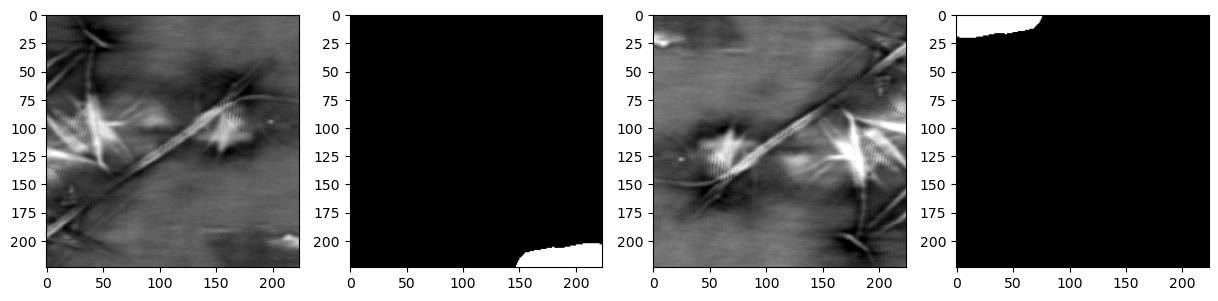

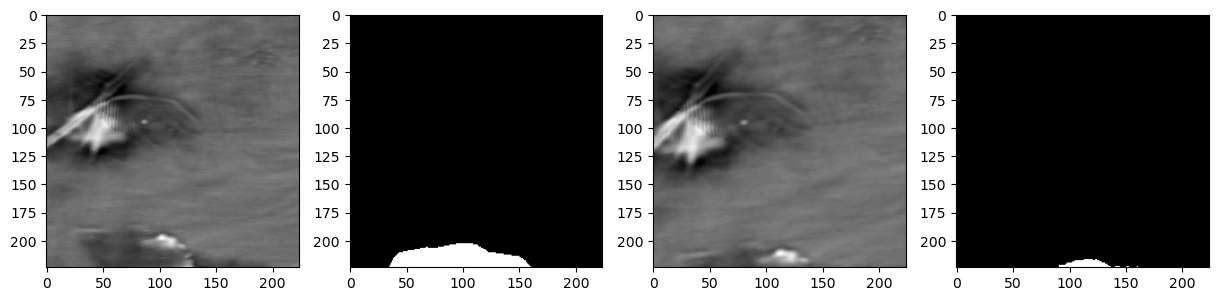

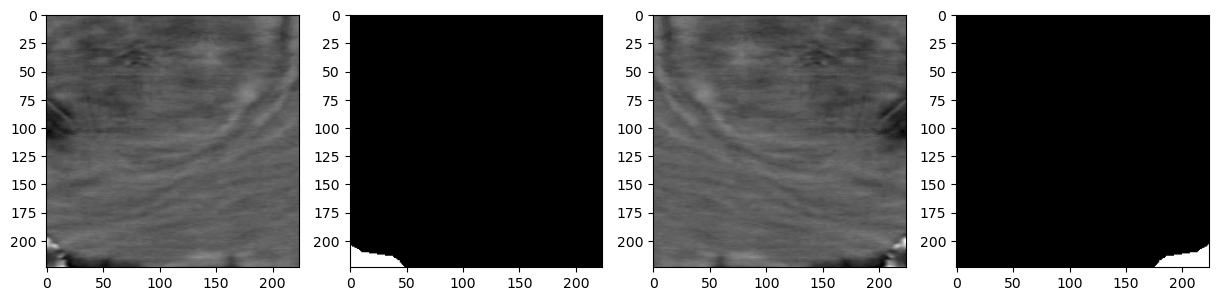

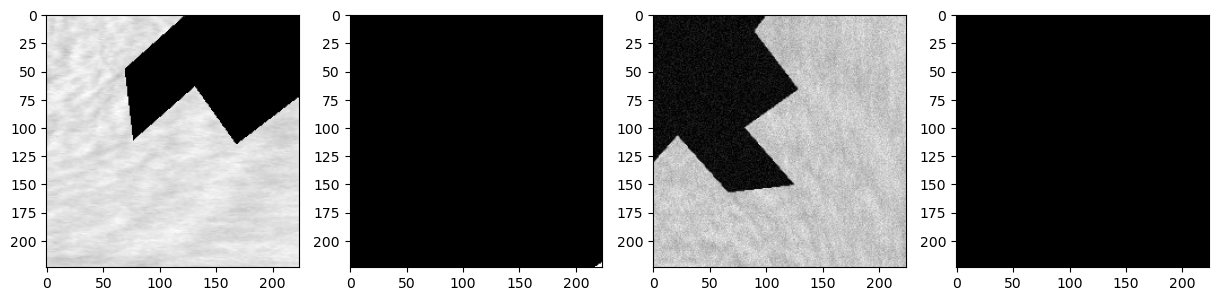

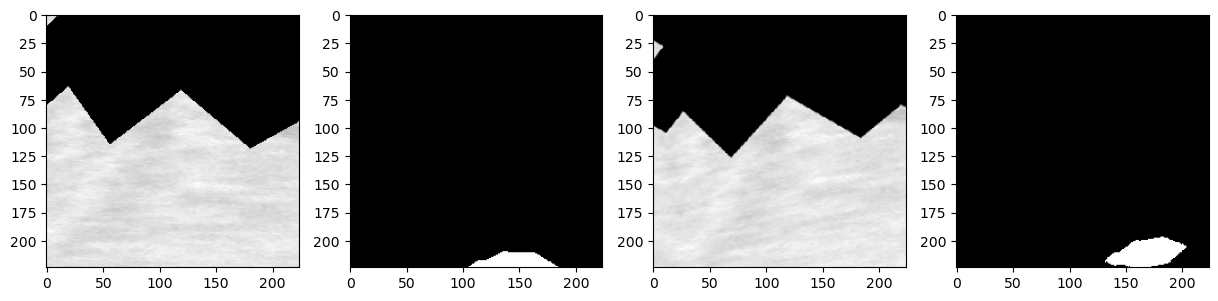

In [22]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [23]:
del plot_dataset
gc.collect()

48120

## model

In [24]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [25]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [26]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [27]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [28]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone se_resnext50_32x4d


## loss

In [29]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [30]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [31]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [32]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [33]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.2646747379359628
th: 0.15, fbeta: 0.29743931742247126
th: 0.2, fbeta: 0.33876889222943246
th: 0.25, fbeta: 0.373286287136723
th: 0.3, fbeta: 0.40610159792857375
th: 0.35, fbeta: 0.43135269073126986
th: 0.4, fbeta: 0.4483190657714203
th: 0.45, fbeta: 0.45409465106648017


best_th: 0.45, fbeta: 0.45409465106648017
Epoch 1 - avg_train_loss: 0.3324  avg_val_loss: 0.2397  time: 150s
Epoch 1 - avgScore: 0.4541
Epoch 1 - Save Best Score: 0.4541 Model
Epoch 1 - Save Best Loss: 0.2397 Model


th: 0.5, fbeta: 0.4338778739137748


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.31410309119424895
th: 0.15, fbeta: 0.3560972413507708
th: 0.2, fbeta: 0.38453561043540907
th: 0.25, fbeta: 0.40534858202834173
th: 0.3, fbeta: 0.42400722406286334
th: 0.35, fbeta: 0.4404106485441668
th: 0.4, fbeta: 0.45578223393158424
th: 0.45, fbeta: 0.46779945888824714


best_th: 0.5, fbeta: 0.4777299512937574
Epoch 2 - avg_train_loss: 0.2545  avg_val_loss: 0.2356  time: 152s
Epoch 2 - avgScore: 0.4777
Epoch 2 - Save Best Score: 0.4777 Model
Epoch 2 - Save Best Loss: 0.2356 Model


th: 0.5, fbeta: 0.4777299512937574


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


th: 0.1, fbeta: 0.2396326386984648
th: 0.15, fbeta: 0.26162602362963033
th: 0.2, fbeta: 0.257145949566441
th: 0.25, fbeta: 0.08191710634845142
th: 0.3, fbeta: 0.022635761210467804
th: 0.35, fbeta: 0.004321204440857826
th: 0.4, fbeta: 0.0
th: 0.45, fbeta: 0.0


best_th: 0.15, fbeta: 0.26162602362963033
Epoch 3 - avg_train_loss: 0.2933  avg_val_loss: 0.2618  time: 151s
Epoch 3 - avgScore: 0.2616


th: 0.5, fbeta: 0.0


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.24873772651800485
th: 0.15, fbeta: 0.2875088214591304
th: 0.2, fbeta: 0.3321749452323171
th: 0.25, fbeta: 0.3699690833252566
th: 0.3, fbeta: 0.4020650217046534
th: 0.35, fbeta: 0.41953397385058505
th: 0.4, fbeta: 0.4231750179594301
th: 0.45, fbeta: 0.40966809745533733


best_th: 0.4, fbeta: 0.4231750179594301
Epoch 4 - avg_train_loss: 0.2791  avg_val_loss: 0.2384  time: 150s
Epoch 4 - avgScore: 0.4232


th: 0.5, fbeta: 0.3737905097167662


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2689497787702875
th: 0.15, fbeta: 0.29356342439856664
th: 0.2, fbeta: 0.3369196809219513
th: 0.25, fbeta: 0.38208666209557957
th: 0.3, fbeta: 0.4213145377508756
th: 0.35, fbeta: 0.4492710221152199
th: 0.4, fbeta: 0.47137162661118437
th: 0.45, fbeta: 0.48692216687510936


best_th: 0.5, fbeta: 0.4931251695173408
Epoch 5 - avg_train_loss: 0.2688  avg_val_loss: 0.2357  time: 151s
Epoch 5 - avgScore: 0.4931
Epoch 5 - Save Best Score: 0.4931 Model
Epoch 5 - Save Best Loss: 0.2357 Model


th: 0.5, fbeta: 0.4931251695173408


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.29913975823619576
th: 0.15, fbeta: 0.34976766965657585
th: 0.2, fbeta: 0.39671806108490515
th: 0.25, fbeta: 0.44109457967240184
th: 0.3, fbeta: 0.4760948438567854
th: 0.35, fbeta: 0.49465133994912286
th: 0.4, fbeta: 0.5015214301587179
th: 0.45, fbeta: 0.490535523212217


best_th: 0.4, fbeta: 0.5015214301587179
Epoch 6 - avg_train_loss: 0.2621  avg_val_loss: 0.2231  time: 151s
Epoch 6 - avgScore: 0.5015
Epoch 6 - Save Best Score: 0.5015 Model
Epoch 6 - Save Best Loss: 0.2231 Model


th: 0.5, fbeta: 0.4559307139896184


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.26266304908524474
th: 0.15, fbeta: 0.29166595521279093
th: 0.2, fbeta: 0.3315990557023922
th: 0.25, fbeta: 0.3656697641730599
th: 0.3, fbeta: 0.3968070931384427
th: 0.35, fbeta: 0.4220970770171742
th: 0.4, fbeta: 0.44128044312441705
th: 0.45, fbeta: 0.45676500007431314


best_th: 0.5, fbeta: 0.4658850749781045
Epoch 7 - avg_train_loss: 0.2586  avg_val_loss: 0.2423  time: 153s
Epoch 7 - avgScore: 0.4659


th: 0.5, fbeta: 0.4658850749781045


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.26061515425398085
th: 0.15, fbeta: 0.2861216449789278
th: 0.2, fbeta: 0.3136975566546094
th: 0.25, fbeta: 0.3437172164349429
th: 0.3, fbeta: 0.37497837027353037
th: 0.35, fbeta: 0.40486751940293114
th: 0.4, fbeta: 0.4324950412210127
th: 0.45, fbeta: 0.45246581923403756


best_th: 0.5, fbeta: 0.47102649124581386
Epoch 8 - avg_train_loss: 0.2520  avg_val_loss: 0.2444  time: 151s
Epoch 8 - avgScore: 0.4710


th: 0.5, fbeta: 0.47102649124581386


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2456037859935999
th: 0.15, fbeta: 0.2541712722831926
th: 0.2, fbeta: 0.2655675263416752
th: 0.25, fbeta: 0.2817866015352502
th: 0.3, fbeta: 0.3012965612643522
th: 0.35, fbeta: 0.3246227061546363
th: 0.4, fbeta: 0.3499005856929952
th: 0.45, fbeta: 0.3780157027519661


best_th: 0.5, fbeta: 0.40669129194992804
Epoch 9 - avg_train_loss: 0.2491  avg_val_loss: 0.2915  time: 150s
Epoch 9 - avgScore: 0.4067


th: 0.5, fbeta: 0.40669129194992804


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2819826519964473
th: 0.15, fbeta: 0.30948712658744987
th: 0.2, fbeta: 0.3329943263903478
th: 0.25, fbeta: 0.3542315628107936
th: 0.3, fbeta: 0.37460046996309854
th: 0.35, fbeta: 0.39294758651393796
th: 0.4, fbeta: 0.41169294329025763
th: 0.45, fbeta: 0.43167490133722974


best_th: 0.5, fbeta: 0.4515759297301747
Epoch 10 - avg_train_loss: 0.2470  avg_val_loss: 0.2529  time: 151s
Epoch 10 - avgScore: 0.4516


th: 0.5, fbeta: 0.4515759297301747


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3382251948803572
th: 0.15, fbeta: 0.3863301290514889
th: 0.2, fbeta: 0.42107216690600485
th: 0.25, fbeta: 0.4480627225159341
th: 0.3, fbeta: 0.46771665882154967
th: 0.35, fbeta: 0.48260161044609373
th: 0.4, fbeta: 0.49538195873393576
th: 0.45, fbeta: 0.5000540858721747


best_th: 0.45, fbeta: 0.5000540858721747
Epoch 11 - avg_train_loss: 0.2424  avg_val_loss: 0.2255  time: 150s
Epoch 11 - avgScore: 0.5001


th: 0.5, fbeta: 0.49782141223467746


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.43403586766073055
th: 0.15, fbeta: 0.47642924448252116
th: 0.2, fbeta: 0.5038563291857394
th: 0.25, fbeta: 0.5207977759702678
th: 0.3, fbeta: 0.5273324593568842
th: 0.35, fbeta: 0.5255892435547629
th: 0.4, fbeta: 0.5172900777349901
th: 0.45, fbeta: 0.5057780197366627


best_th: 0.3, fbeta: 0.5273324593568842
Epoch 12 - avg_train_loss: 0.2387  avg_val_loss: 0.2402  time: 150s
Epoch 12 - avgScore: 0.5273
Epoch 12 - Save Best Score: 0.5273 Model
Epoch 12 - Save Best Loss: 0.2402 Model


th: 0.5, fbeta: 0.48739798075224555


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.37145860341068276
th: 0.15, fbeta: 0.41584709999989855
th: 0.2, fbeta: 0.45104272477241236
th: 0.25, fbeta: 0.4805385163980521
th: 0.3, fbeta: 0.49962814610261586
th: 0.35, fbeta: 0.5148327215690612
th: 0.4, fbeta: 0.5235126091553225
th: 0.45, fbeta: 0.5281946081142167


best_th: 0.45, fbeta: 0.5281946081142167
Epoch 13 - avg_train_loss: 0.2370  avg_val_loss: 0.2268  time: 150s
Epoch 13 - avgScore: 0.5282
Epoch 13 - Save Best Score: 0.5282 Model
Epoch 13 - Save Best Loss: 0.2268 Model


th: 0.5, fbeta: 0.5235704076946439


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3457078325221533
th: 0.15, fbeta: 0.3814547290741198
th: 0.2, fbeta: 0.41327778677952887
th: 0.25, fbeta: 0.43395773303612933
th: 0.3, fbeta: 0.4496395159309591
th: 0.35, fbeta: 0.4648368621569085
th: 0.4, fbeta: 0.4760483678873765
th: 0.45, fbeta: 0.47978496588884384


best_th: 0.45, fbeta: 0.47978496588884384
Epoch 14 - avg_train_loss: 0.2339  avg_val_loss: 0.2513  time: 150s
Epoch 14 - avgScore: 0.4798


th: 0.5, fbeta: 0.47830551208999283


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.31448506682832583
th: 0.15, fbeta: 0.3591367369526357
th: 0.2, fbeta: 0.4070374643208535
th: 0.25, fbeta: 0.44952402252119
th: 0.3, fbeta: 0.48242072247576867
th: 0.35, fbeta: 0.5096122587815258
th: 0.4, fbeta: 0.5291031875902011
th: 0.45, fbeta: 0.5436026479853967


best_th: 0.5, fbeta: 0.5474186536689006
Epoch 15 - avg_train_loss: 0.2312  avg_val_loss: 0.2146  time: 150s
Epoch 15 - avgScore: 0.5474
Epoch 15 - Save Best Score: 0.5474 Model
Epoch 15 - Save Best Loss: 0.2146 Model


th: 0.5, fbeta: 0.5474186536689006


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3560387011395535
th: 0.15, fbeta: 0.4159217193182203
th: 0.2, fbeta: 0.46944982027121485
th: 0.25, fbeta: 0.5028918461302142
th: 0.3, fbeta: 0.5265824145627435
th: 0.35, fbeta: 0.5404685765603934
th: 0.4, fbeta: 0.5425976560321925
th: 0.45, fbeta: 0.5384480038261136


best_th: 0.4, fbeta: 0.5425976560321925
Epoch 16 - avg_train_loss: 0.2265  avg_val_loss: 0.2191  time: 150s
Epoch 16 - avgScore: 0.5426


th: 0.5, fbeta: 0.529577097340491


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.36547199727832624
th: 0.15, fbeta: 0.40047845473439436
th: 0.2, fbeta: 0.42556486465338506
th: 0.25, fbeta: 0.4436550834103388
th: 0.3, fbeta: 0.45755061011208664
th: 0.35, fbeta: 0.47112039510494347
th: 0.4, fbeta: 0.4814986365726647
th: 0.45, fbeta: 0.4872374866352787


best_th: 0.5, fbeta: 0.4894092443088247
Epoch 17 - avg_train_loss: 0.2232  avg_val_loss: 0.2363  time: 151s
Epoch 17 - avgScore: 0.4894


th: 0.5, fbeta: 0.4894092443088247


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.375655446105873
th: 0.15, fbeta: 0.4194749606809772
th: 0.2, fbeta: 0.4535336938660171
th: 0.25, fbeta: 0.47939879268889907
th: 0.3, fbeta: 0.4942128788416922
th: 0.35, fbeta: 0.5067754801551495
th: 0.4, fbeta: 0.5117641011656928
th: 0.45, fbeta: 0.5111713401782584


best_th: 0.4, fbeta: 0.5117641011656928
Epoch 18 - avg_train_loss: 0.2176  avg_val_loss: 0.2370  time: 150s
Epoch 18 - avgScore: 0.5118


th: 0.5, fbeta: 0.49851394246249725


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3173943657809447
th: 0.15, fbeta: 0.3482558244692081
th: 0.2, fbeta: 0.3737876929995951
th: 0.25, fbeta: 0.39381598879293805
th: 0.3, fbeta: 0.4114053656231197
th: 0.35, fbeta: 0.42839300130776786
th: 0.4, fbeta: 0.4433192939211942
th: 0.45, fbeta: 0.45313130574891475


best_th: 0.5, fbeta: 0.45574904447334463
Epoch 19 - avg_train_loss: 0.2150  avg_val_loss: 0.2449  time: 151s
Epoch 19 - avgScore: 0.4557


th: 0.5, fbeta: 0.45574904447334463


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4134971003230002
th: 0.15, fbeta: 0.44986738298680645
th: 0.2, fbeta: 0.4798764571860551
th: 0.25, fbeta: 0.49241672317383245
th: 0.3, fbeta: 0.4989780129583561
th: 0.35, fbeta: 0.4976567232496653
th: 0.4, fbeta: 0.4904410879961124
th: 0.45, fbeta: 0.47808759579925453


best_th: 0.3, fbeta: 0.4989780129583561
Epoch 20 - avg_train_loss: 0.2110  avg_val_loss: 0.2651  time: 150s
Epoch 20 - avgScore: 0.4990


th: 0.5, fbeta: 0.4626644065119452


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3831826957635197
th: 0.15, fbeta: 0.421305686167077
th: 0.2, fbeta: 0.4447851516188358
th: 0.25, fbeta: 0.464098238520786
th: 0.3, fbeta: 0.4806554802644393
th: 0.35, fbeta: 0.4953468365813851
th: 0.4, fbeta: 0.5016348589885574
th: 0.45, fbeta: 0.5047157157190656


best_th: 0.5, fbeta: 0.5049686660580728
Epoch 21 - avg_train_loss: 0.2067  avg_val_loss: 0.2428  time: 150s
Epoch 21 - avgScore: 0.5050


th: 0.5, fbeta: 0.5049686660580728


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3514580098109425
th: 0.15, fbeta: 0.39416895288563253
th: 0.2, fbeta: 0.4271575547535053
th: 0.25, fbeta: 0.4577170364551675
th: 0.3, fbeta: 0.48199504208398425
th: 0.35, fbeta: 0.5035167859092065
th: 0.4, fbeta: 0.5190460468244338
th: 0.45, fbeta: 0.5325669480226337


best_th: 0.5, fbeta: 0.5429675095728903
Epoch 22 - avg_train_loss: 0.2033  avg_val_loss: 0.2316  time: 150s
Epoch 22 - avgScore: 0.5430


th: 0.5, fbeta: 0.5429675095728903


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.40401180773020734
th: 0.15, fbeta: 0.45649857789555653
th: 0.2, fbeta: 0.4963434342507663
th: 0.25, fbeta: 0.5235025847217964
th: 0.3, fbeta: 0.5369620151166152
th: 0.35, fbeta: 0.5453593828687736
th: 0.4, fbeta: 0.5507961023728224
th: 0.45, fbeta: 0.5489599054571221


best_th: 0.4, fbeta: 0.5507961023728224
Epoch 23 - avg_train_loss: 0.2000  avg_val_loss: 0.2337  time: 150s
Epoch 23 - avgScore: 0.5508
Epoch 23 - Save Best Score: 0.5508 Model
Epoch 23 - Save Best Loss: 0.2337 Model


th: 0.5, fbeta: 0.5380110363811439


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3584848471018438
th: 0.15, fbeta: 0.3979620419205082
th: 0.2, fbeta: 0.4303001212455773
th: 0.25, fbeta: 0.4576753543303073
th: 0.3, fbeta: 0.47948140459201355
th: 0.35, fbeta: 0.4973929204064939
th: 0.4, fbeta: 0.5138312043897536
th: 0.45, fbeta: 0.5248986799565187


best_th: 0.5, fbeta: 0.5290513960967255
Epoch 24 - avg_train_loss: 0.1935  avg_val_loss: 0.2303  time: 150s
Epoch 24 - avgScore: 0.5291


th: 0.5, fbeta: 0.5290513960967255


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.42764251240433354
th: 0.15, fbeta: 0.4786347605940015
th: 0.2, fbeta: 0.507884779021071
th: 0.25, fbeta: 0.5265509774914486
th: 0.3, fbeta: 0.5433950914211506
th: 0.35, fbeta: 0.5554687026510663
th: 0.4, fbeta: 0.5595795533911183
th: 0.45, fbeta: 0.5536662725353885


best_th: 0.4, fbeta: 0.5595795533911183
Epoch 25 - avg_train_loss: 0.1945  avg_val_loss: 0.2374  time: 151s
Epoch 25 - avgScore: 0.5596
Epoch 25 - Save Best Score: 0.5596 Model
Epoch 25 - Save Best Loss: 0.2374 Model


th: 0.5, fbeta: 0.5431021584821794


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3813086575225001
th: 0.15, fbeta: 0.4296485986540676
th: 0.2, fbeta: 0.47096417989682227
th: 0.25, fbeta: 0.5017565239446453
th: 0.3, fbeta: 0.5250543762661398
th: 0.35, fbeta: 0.5422373049941238
th: 0.4, fbeta: 0.5489545755176569
th: 0.45, fbeta: 0.5484377518303202


best_th: 0.4, fbeta: 0.5489545755176569
Epoch 26 - avg_train_loss: 0.1919  avg_val_loss: 0.2306  time: 151s
Epoch 26 - avgScore: 0.5490


th: 0.5, fbeta: 0.5425009562405835


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3806785526908543
th: 0.15, fbeta: 0.41988162975116916
th: 0.2, fbeta: 0.4491305448824114
th: 0.25, fbeta: 0.4717975574960032
th: 0.3, fbeta: 0.48861050805774625
th: 0.35, fbeta: 0.5048496552337373
th: 0.4, fbeta: 0.51476258081847
th: 0.45, fbeta: 0.5169237705265447


best_th: 0.45, fbeta: 0.5169237705265447
Epoch 27 - avg_train_loss: 0.1859  avg_val_loss: 0.2452  time: 151s
Epoch 27 - avgScore: 0.5169


th: 0.5, fbeta: 0.5121897468762637


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.39858940651705105
th: 0.15, fbeta: 0.4364657948160646
th: 0.2, fbeta: 0.4612296359792644
th: 0.25, fbeta: 0.48061600707305446
th: 0.3, fbeta: 0.49482347032076096
th: 0.35, fbeta: 0.5041342829304958
th: 0.4, fbeta: 0.5112911703131697
th: 0.45, fbeta: 0.5117003777148285


best_th: 0.45, fbeta: 0.5117003777148285
Epoch 28 - avg_train_loss: 0.1854  avg_val_loss: 0.2529  time: 151s
Epoch 28 - avgScore: 0.5117


th: 0.5, fbeta: 0.5075904213345525


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.43145074148947243
th: 0.15, fbeta: 0.4716676902018035
th: 0.2, fbeta: 0.49335314296215604
th: 0.25, fbeta: 0.509327398538832
th: 0.3, fbeta: 0.5209780424563395
th: 0.35, fbeta: 0.5285865591702408
th: 0.4, fbeta: 0.5284506330274354
th: 0.45, fbeta: 0.5253493577336847


best_th: 0.35, fbeta: 0.5285865591702408
Epoch 29 - avg_train_loss: 0.1818  avg_val_loss: 0.2510  time: 151s
Epoch 29 - avgScore: 0.5286


th: 0.5, fbeta: 0.5166347063300775


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3990608814634087
th: 0.15, fbeta: 0.4411186323358543
th: 0.2, fbeta: 0.47120019642024996
th: 0.25, fbeta: 0.4915989907125081
th: 0.3, fbeta: 0.506992914376328
th: 0.35, fbeta: 0.5187593346922932
th: 0.4, fbeta: 0.5270528066257113
th: 0.45, fbeta: 0.5270772938289787


best_th: 0.45, fbeta: 0.5270772938289787
Epoch 30 - avg_train_loss: 0.1802  avg_val_loss: 0.2443  time: 151s
Epoch 30 - avgScore: 0.5271


th: 0.5, fbeta: 0.5253095152114603


In [34]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [35]:
mask_pred = check_point['preds']

In [36]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.42764251240433354
th: 0.15, fbeta: 0.4786347605940015
th: 0.2, fbeta: 0.507884779021071
th: 0.25, fbeta: 0.5265509774914486
th: 0.3, fbeta: 0.5433950914211506
th: 0.35, fbeta: 0.5554687026510663
th: 0.4, fbeta: 0.5595795533911183
th: 0.45, fbeta: 0.5536662725353885


best_th: 0.4, fbeta: 0.5595795533911183


th: 0.5, fbeta: 0.5431021584821794


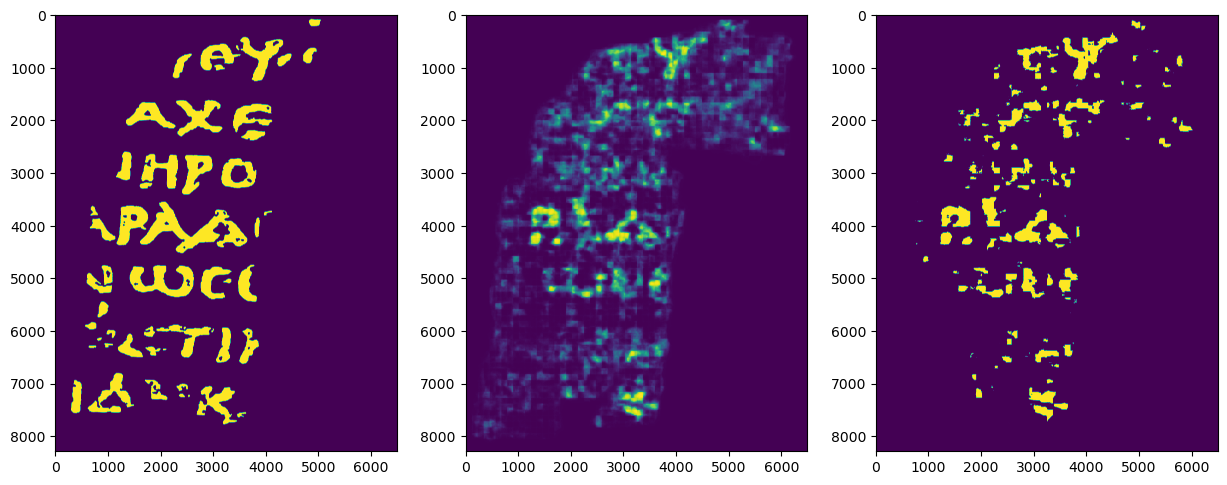

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([39803534.,  4361600.,  2421984.,  1454624.,  1038537.,   804412.,
          653679.,   542837.,   443881.,   376977.,   310710.,   258623.,
          241613.,   218573.,   195185.,   166096.,   144875.,   145912.,
          136092.,   119104.]),
 array([2.67064857e-12, 4.99261960e-02, 9.98523921e-02, 1.49778588e-01,
        1.99704784e-01, 2.49630980e-01, 2.99557176e-01, 3.49483372e-01,
        3.99409568e-01, 4.49335764e-01, 4.99261960e-01, 5.49188156e-01,
        5.99114352e-01, 6.49040549e-01, 6.98966745e-01, 7.48892941e-01,
        7.98819137e-01, 8.48745333e-01, 8.98671529e-01, 9.48597725e-01,
        9.98523921e-01]),
 <BarContainer object of 20 artists>)

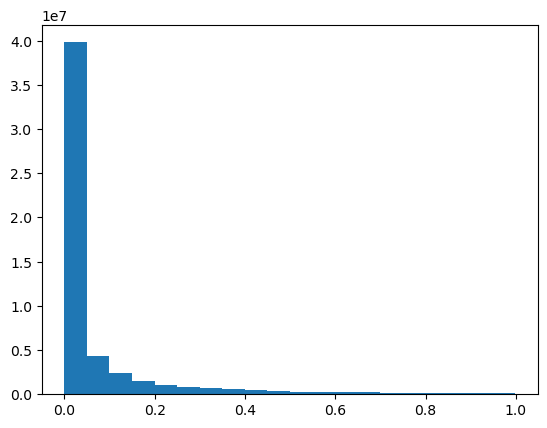

In [38]:
plt.hist(mask_pred.flatten(), bins=20)

In [39]:
# GPU VRAM 5.2GB/16.0GB A4000